In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
input_dim=784 #Mnist: 28x28 images -> input dimension = 784
hidden_dim=128 #width of the hidden layer
output_dim=10 #10 classes (the digits in mnist)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
                
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Slight modification to ```ff_main.py``` file: the ```test``` method returns the test rate.

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [6]:
batch_size = 100
test_batch_size= 1000
epochs = 14
lr = 0.1
gamma = 0.7
seed = 1
log_interval = 60
save_model=False

In [7]:
torch.manual_seed(seed)

device = "cpu" # "cuda"

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if device == "cuda":
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}

In [12]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=False,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False, download=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [13]:
model = Net().to(device)

optimizers = {}
optimizers['ASGD'] = optim.ASGD(model.parameters(), lr=lr)
optimizers['SGD'] = optim.SGD(model.parameters(), lr=lr)
optimizers['Adagrad'] = optim.Adagrad(model.parameters(), lr=lr)
optimizers['Adam'] = optim.Adam(model.parameters(), lr=lr)
optimizers['Adamax'] = optim.Adamax(model.parameters(), lr=lr)

In [20]:
accs = {}
epochs = 5
for name, optimizer in optimizers.items():
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    acc = []
    print(f"Training using the optimezer '{name}'")
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        a = test(model, device, test_loader)
        acc.append(a)
        scheduler.step()
    accs[name] = acc
    print()

Training using the optimezer 'ASGD'
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.010733
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.042886
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.055763
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.065487
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.047050
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.086525
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.084188
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.168876
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.100660
Train Epoch: 1 [54000/60000 (90%)]	Loss: 0.080115

Test set: Average loss: 0.1378, Accuracy: 9606/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.010532
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.041278
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.054538
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.065596
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.047497
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.086856
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.083515
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.168553
Train Epoch: 2 

Train Epoch: 5 [42000/60000 (70%)]	Loss: 0.161206
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.091544
Train Epoch: 5 [54000/60000 (90%)]	Loss: 0.076734

Test set: Average loss: 0.1355, Accuracy: 9608/10000 (96%)


Training using the optimezer 'Adam'
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.010328
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.187323
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.489798
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.441586
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.794939
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.286880
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.098281
Train Epoch: 1 [42000/60000 (70%)]	Loss: 1.056878
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.265502
Train Epoch: 1 [54000/60000 (90%)]	Loss: 1.374557

Test set: Average loss: 1.1910, Accuracy: 6193/10000 (62%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.110807
Train Epoch: 2 [6000/60000 (10%)]	Loss: 1.048395
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.192937
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.862414
Tra

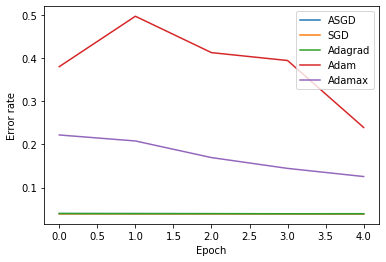

In [22]:
import numpy as np
for name in optimizers:
    plt.plot(1 - np.array(accs[name]), label=name)

plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.legend()
plt.show()

In [25]:
for name, vals in accs.items():
    print(name, vals)

ASGD [0.9606, 0.9606, 0.9609, 0.961, 0.9613]
SGD [0.9612, 0.9611, 0.9612, 0.9612, 0.9613]
Adagrad [0.9603, 0.9606, 0.9606, 0.9609, 0.9608]
Adam [0.6193, 0.5023, 0.5868, 0.6051, 0.7606]
Adamax [0.778, 0.7919, 0.8305, 0.8556, 0.8745]
